# Depth Anything V2 Large (Hugging Face Transformers)

This notebook demonstrates the use of the state-of-the-art Depth Anything V2 Large model for monocular depth estimation (MDE). The model leverages the DPT architecture with a DINOv2 backbone to provide robust and fine-grained depth predictions.

## 1. Setup and Imports

We start by installing the necessary libraries and importing the required modules.

In [1]:
import torch
from transformers import pipeline, AutoImageProcessor, AutoModelForDepthEstimation
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

# --- Configuration ---
MODEL_ID = "depth-anything/Depth-Anything-V2-Large-hf"
# Use CUDA if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Example image URL for demonstration
IMAGE_URL = 'http://images.cocodataset.org/val2017/000000039769.jpg'

def load_image_from_url(url):
    """Fetches an image from a URL and returns a PIL Image object."""
    try:
        image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
        print(f"Image loaded successfully (Size: {image.size})")
        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

Using device: cuda


## 2. Zero-Shot Depth Estimation using pipeline (Simple)

The easiest way to use the model is via the Hugging Face `pipeline`. This abstracts away the pre-processing and model loading steps.

Image loaded successfully (Size: (640, 480))
Loading pipeline for depth-anything/Depth-Anything-V2-Large-hf...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/503 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Running inference...


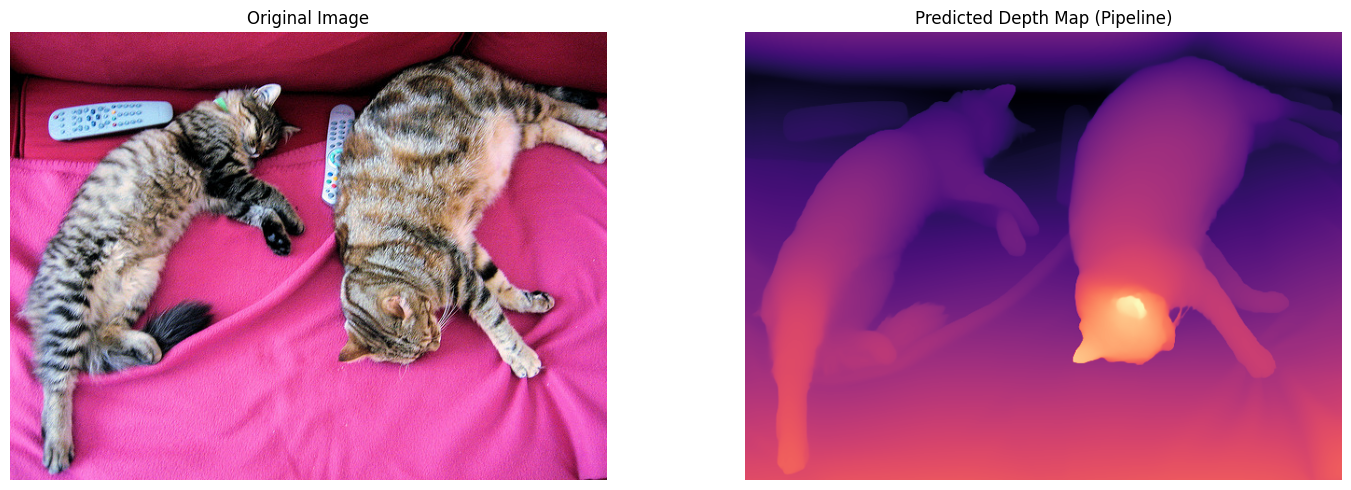

In [3]:
# Load the image
image = load_image_from_url(IMAGE_URL)

# 1. Load the depth estimation pipeline
print(f"Loading pipeline for {MODEL_ID}...")
pipe = pipeline(task="depth-estimation", model=MODEL_ID, device=device)

# 2. Run inference
print("Running inference...")
# The output is a list of dictionaries, where the 'depth' key contains the predicted depth map (PIL Image)
output = pipe(image)
depth_image = output["depth"]

# 3. Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original Image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Depth Map 
axes[1].imshow(depth_image, cmap='magma') # Using magma for common depth visualization
axes[1].set_title("Predicted Depth Map (Pipeline)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 3. Depth Estimation using AutoModel and AutoProcessor (Advanced)

This method gives you direct access to the raw tensor output and allows you to manually handle interpolation and visualization, which is necessary for integration into larger projects.

Image loaded successfully (Size: (640, 480))
Loading processor and model classes for depth-anything/Depth-Anything-V2-Large-hf...


Loading weights:   0%|          | 0/503 [00:00<?, ?it/s]

Running inference and extracting raw prediction...


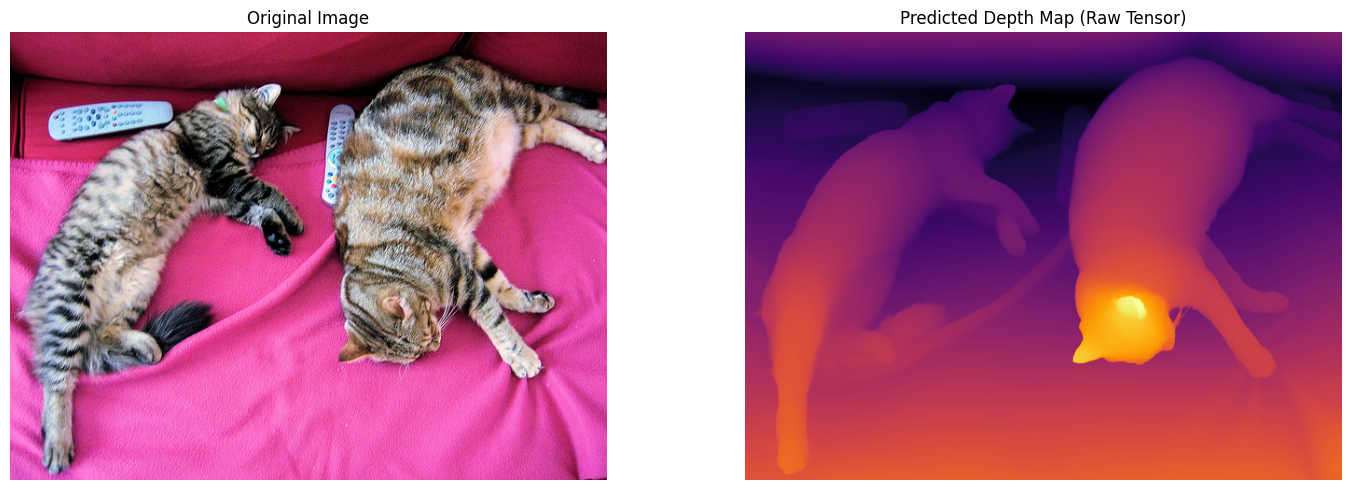

In [4]:
# Load the image
image = load_image_from_url(IMAGE_URL)

# 1. Load processor and model
print(f"Loading processor and model classes for {MODEL_ID}...")
image_processor = AutoImageProcessor.from_pretrained(MODEL_ID)
model = AutoModelForDepthEstimation.from_pretrained(MODEL_ID).to(device)

# 2. Prepare image for the model
# The processor scales and normalizes the image
inputs = image_processor(images=image, return_tensors="pt").to(device)

# 3. Run inference (no gradient computation needed)
print("Running inference and extracting raw prediction...")
with torch.no_grad():
    outputs = model(**inputs)
    # The output tensor contains the predicted depth map (before resizing)
    predicted_depth = outputs.predicted_depth

# 4. Interpolate to original size
# The model predicts depth at a lower resolution (e.g., 384x384). 
# We must resize it to match the original image size for display.
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1], # PIL image size is (W, H), interpolation expects (H, W)
    mode="bicubic",
    align_corners=False,
)

# 5. Normalize and convert to NumPy for visualization
# Remove batch and channel dimensions, move to CPU, and convert
output_np = prediction.squeeze().cpu().numpy()

# 6. Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original Image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Depth Map (Advanced)
# The depth values are relative (not metric distances)
axes[1].imshow(output_np, cmap='inferno') 
axes[1].set_title("Predicted Depth Map (Raw Tensor)")
axes[1].axis('off')

plt.tight_layout()
plt.show()